# AkerBP news 

## Imports

In [3]:
# Installing packages
!pip install hdbscan beautifulsoup4 keybert pycryptodome sentence-transformers PyPDF2 --quiet

# Importing the transformer
from sentence_transformers import SentenceTransformer

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sc
import requests
import torch
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from sklearn.manifold import TSNE
from keybert import KeyBERT
from sklearn.decomposition import PCA

# Special imports for plots
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


# Imports for the widgets
from ipywidgets import widgets, interact
from IPython.display import display, clear_output

#Imports for decrypting urls to pdfs or html
import PyPDF2
import requests
from bs4 import BeautifulSoup
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

DEPRECATION: Loading egg at /opt/anaconda3/envs/embed/lib/python3.12/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


/opt/anaconda3/envs/embed/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
import requests
from bs4 import BeautifulSoup

url = "https://akerbp.com/en/news/?filter=news"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

content_section = soup.find("div", class_="grid archive-grid")
links = content_section.find_all("a", class_="post-item")

links_by_year = {}

for link in links:
    href = link.get("href")
    post_date_div = link.find("div", class_="post-date")
    if href and post_date_div:
        post_date = post_date_div.text.strip()
        year = post_date.split(".")[-1]
        if year not in links_by_year:
            links_by_year[year] = []
        links_by_year[year].append(href)

for i in range(2, 13):
    url = f'https://akerbp.com/en/news/page/{i}/?filter=news'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    content_section = soup.find("div", class_="grid archive-grid")
    links = content_section.find_all("a", class_="post-item")

    for link in links:
        href = link.get("href")
        post_date_div = link.find_next("div", class_="post-date")
        if href and post_date_div:
            post_date = post_date_div.text.strip()
            year = post_date.split(".")[-1]
            if year not in links_by_year:
                links_by_year[year] = []
            links_by_year[year].append(href)

links_by_year

{'2024': ['https://akerbp.com/en/lukas-mosser-wins-the-arie-van-weelden-award/',
  'https://akerbp.com/en/aker-bp-won-the-exploration-innovation-prize-for-the-ost-frigg-beta-epsilon-discovery/',
  'https://akerbp.com/en/aker-bp-organized-hackathon-in-collaboration-with-cognite-aker-solutions-microsoft-and-tietoevry/',
  'https://akerbp.com/en/aker-bp-increases-share-of-norwegian-meat-offshore-from-25-to-75-per-cent/',
  'https://akerbp.com/en/can-artificial-intelligence-help-us-find-oil/',
  'https://akerbp.com/en/a-bright-idea-ensures-significant-emission-reductions/',
  'https://akerbp.com/en/aker-bp-awarded-27-licenses-in-apa-2023/',
  'https://akerbp.com/en/kelp-farming-plant-to-remove-co2-from-the-atmosphere/',
  'https://akerbp.com/en/construction-starts-on-billion-kroner-project-at-worley-rosenberg/'],
 '2023': ['https://akerbp.com/en/the-first-steel-has-been-cut-for-the-symra-modifications-project/',
  'https://akerbp.com/en/effective-response-to-oil-spill-at-alvheim/',
  'http

In [5]:
import requests
from bs4 import BeautifulSoup

def extract_article_content(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")


    article_content = ""
    h1 = soup.find("h1", {"class": "entry-title"})
    if h1:
        article_content += h1.text.strip() + "."

    main_content = soup.find("div", {"class": "site-content"})
    if main_content:
        paragraphs = main_content.find_all("p")
        for p in paragraphs:
            paragraph_text = p.text.strip()
            article_content += paragraph_text + " "

    return article_content.strip()

#Eksempel
url = 'https://akerbp.com/en/edvard-grieg-and-ivar-aasen-runs-on-power-from-shore/'
article = extract_article_content(url)




In [6]:

articles = {}

for year, urls in links_by_year.items():
    for url in urls:
        content = extract_article_content(url)
        if content:
            articles[url] = content



In [7]:
from bs4 import BeautifulSoup
import requests
import time

articles_by_year = {}
#Request-limit, dette tar tid.
for year, urls in links_by_year.items():
    articles_by_year[year] = []
    for url in urls:
        success = False
        attempts = 0
        wait_time = 10
        while not success and attempts < 3:
            text = extract_article_content(url)
            if text:
                articles_by_year[year].append(text)
                success = True
            else:
                attempts += 1
                print(f"Retrying URL {url}, attempt {attempts}")
                time.sleep(wait_time)
                wait_time *= 2

for year in articles_by_year:
    print(f"{year}: Nmber of articles = {len(articles_by_year[year])}")


2024: Nmber of articles = 9
2023: Nmber of articles = 30
2022: Nmber of articles = 10
2021: Nmber of articles = 20
2020: Nmber of articles = 15
2019: Nmber of articles = 8
2018: Nmber of articles = 17
2017: Nmber of articles = 23
2016: Nmber of articles = 9


## Splitting text

In [8]:
def split_up_text(article, n):
    assert n <= 400, "n must be 400 or less."

    words = article.strip().split()
    if len(words) <= n:
        return [article]
    else:
        new_article = []
        for i in range(0, len(words), n):
            chunk = words[i:i+n]
            new_article.append(' '.join(chunk))
        return new_article

In [9]:
# Split articles within each year
split_articles_by_year = {}

for year, articles in articles_by_year.items():
    split_articles_by_year[year] = []
    for article in articles:
        split_articles_by_year[year].extend(split_up_text(article, 400))

In [ ]:
with open("AkerBP_split_articles.pkl","wb") as file:
    pickle.dump(split_articles_by_year, file)

## Embedding

In [10]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [11]:
def embed_text(t):
    embeddings = model.encode(t, convert_to_tensor=True)
    return embeddings

In [12]:
embed_2024 = embed_text(split_articles_by_year["2024"])
print(embed_2024)
embed_2024.shape

tensor([[ 0.2877,  0.6323, -0.4107,  ..., -0.8942, -0.2675,  0.1809],
        [ 0.4125,  0.6612,  0.2032,  ..., -1.2862, -0.4356,  0.4908],
        [ 0.7956,  0.2168, -0.0530,  ..., -0.8418, -0.0854,  0.0643],
        ...,
        [ 0.4223,  0.5186,  0.1983,  ..., -0.5168, -0.7231,  0.6898],
        [ 0.3763,  0.6507,  0.1034,  ..., -0.8237, -0.5637,  0.8191],
        [ 0.1510,  0.6722, -0.0127,  ..., -1.1663, -0.8259,  0.4651]])


torch.Size([12, 1024])

In [13]:
embed_2023 = embed_text(split_articles_by_year["2023"])
print(embed_2023)
embed_2023.shape

tensor([[ 0.0694,  0.6444, -0.2188,  ..., -0.6613,  0.0667,  0.0650],
        [-0.1613,  1.0712,  0.2866,  ..., -1.2080, -0.4630,  0.8653],
        [-0.1685,  0.5183, -0.3775,  ..., -0.6773, -0.0659,  0.7731],
        ...,
        [ 0.2891,  0.3924, -0.3258,  ..., -1.1125, -0.5395,  0.2103],
        [ 0.4015,  0.1735, -0.1496,  ..., -0.9507, -0.2798,  0.6117],
        [ 0.2145, -0.2788, -0.2726,  ..., -0.9295, -0.6621,  0.3105]])


torch.Size([45, 1024])

In [14]:
embed_2022 = embed_text(split_articles_by_year["2022"])
print(embed_2022)
embed_2022.shape

tensor([[-2.8952e-01,  4.5896e-01,  9.9733e-04,  ..., -6.6960e-01,
          1.0121e-01, -1.9596e-01],
        [ 5.9688e-01,  1.6638e-01, -1.5208e-02,  ..., -1.0127e+00,
         -4.6173e-01,  1.4277e-01],
        [ 5.0563e-01,  3.5444e-01, -2.2927e-01,  ..., -9.6766e-01,
         -4.1645e-01,  3.8889e-01],
        ...,
        [ 1.0952e-01,  5.7199e-01, -2.3914e-01,  ..., -1.3021e+00,
         -6.8761e-01,  2.9683e-01],
        [-1.1890e-01,  4.9401e-01, -1.5558e-01,  ..., -1.1058e+00,
         -8.2420e-01,  3.5886e-01],
        [ 5.2558e-01,  5.5628e-01, -1.0457e-01,  ..., -1.0493e+00,
         -5.8540e-01,  2.8446e-01]])


torch.Size([14, 1024])

In [15]:
embed_2021 = embed_text(split_articles_by_year["2021"])
print(embed_2021)
embed_2021.shape

tensor([[ 0.5052,  0.4273,  0.2184,  ..., -1.0478, -0.5375,  0.3722],
        [ 0.1999,  0.8775,  0.0719,  ..., -1.3577, -0.6458,  0.1168],
        [-0.1091,  0.4710,  0.3216,  ..., -0.8596, -0.5163,  0.0063],
        ...,
        [ 0.2971,  0.5122, -0.1863,  ..., -1.0996, -0.1136, -0.0164],
        [ 0.7033,  0.6842, -0.0645,  ..., -1.1346, -0.7455,  0.1281],
        [ 0.0939,  0.2491, -0.1934,  ..., -1.2855, -0.8391,  0.1247]])


torch.Size([41, 1024])

In [16]:
embed_2020 = embed_text(split_articles_by_year["2020"])
print(embed_2020)
embed_2020.shape

tensor([[ 0.4993,  0.6030, -0.1472,  ..., -0.8735, -0.3982,  0.4134],
        [ 0.4429,  0.1686, -0.6819,  ..., -1.5875, -0.2460,  0.6463],
        [-0.2089,  0.2678, -0.2326,  ..., -1.1095, -0.3285, -0.0422],
        ...,
        [ 0.5532,  0.5263,  0.0957,  ..., -1.2230, -0.7462,  0.1205],
        [ 0.2604,  0.2992, -0.2622,  ..., -1.2650, -0.5916,  0.1192],
        [ 0.5461,  1.0267,  0.0774,  ..., -0.9478, -1.0220,  0.3620]])


torch.Size([25, 1024])

In [17]:
embed_2019 = embed_text(split_articles_by_year["2019"])
print(embed_2019)
embed_2019.shape

tensor([[ 0.4289,  1.1394,  0.0535,  ..., -0.8454, -0.4710,  0.4060],
        [ 0.5888,  0.9601,  0.0068,  ..., -1.1764, -0.5860,  0.5792],
        [ 0.0622,  0.4552, -0.4480,  ..., -0.9434, -0.3307,  0.1953],
        ...,
        [ 0.1996,  0.5818,  0.1689,  ..., -0.8852, -0.6152,  0.2631],
        [ 0.4608,  0.3241, -0.0498,  ..., -1.4421, -0.5831,  0.3422],
        [ 0.1485,  0.4089,  0.0553,  ..., -1.2780, -0.3840,  0.3695]])


torch.Size([16, 1024])

In [18]:
embed_2018 = embed_text(split_articles_by_year["2018"])
print(embed_2018)
embed_2018.shape

tensor([[-0.0797,  0.9024,  0.0683,  ..., -1.4867, -0.2232,  0.1170],
        [ 0.1758,  0.7906,  0.0247,  ..., -0.5777, -0.7435,  0.1197],
        [ 0.5035,  0.7911,  0.0525,  ..., -1.0926, -0.6609,  0.2916],
        ...,
        [ 0.0342, -0.0530, -0.4933,  ..., -1.1508, -0.7978, -0.1262],
        [ 0.2228,  0.4933,  0.2009,  ..., -0.9064, -0.9781, -0.0212],
        [-0.0256,  0.3117,  0.3046,  ..., -1.1773, -1.1125,  0.1285]])


torch.Size([22, 1024])

In [19]:
embed_2017 = embed_text(split_articles_by_year["2017"])
print(embed_2017)
embed_2017.shape

tensor([[ 0.7433,  0.4677,  0.0443,  ..., -1.1469, -0.3872,  0.9254],
        [ 0.6138, -0.1159,  0.4069,  ..., -1.0623, -0.7693, -0.3388],
        [ 0.0155, -0.0627, -0.0455,  ..., -1.3409, -0.9286, -0.1727],
        ...,
        [ 0.2910,  0.6634, -0.0056,  ..., -1.2971, -0.6773,  0.3262],
        [ 0.0364,  0.6136, -0.5038,  ..., -1.4586, -0.8408,  0.2648],
        [ 0.1037,  0.7372, -0.0411,  ..., -1.0739, -0.4020,  0.3491]])


torch.Size([27, 1024])

In [20]:
embed_2016 = embed_text(split_articles_by_year["2016"])
print(embed_2016)
embed_2016.shape

tensor([[-3.0456e-01,  9.5785e-01,  1.3594e-01,  ..., -1.3340e+00,
          4.5302e-01,  3.8307e-01],
        [ 5.8445e-01,  4.7834e-01, -3.7462e-01,  ..., -1.1840e+00,
         -3.3869e-01, -3.3566e-01],
        [ 2.4996e-01,  1.7104e-01, -1.3151e-01,  ..., -1.2424e+00,
         -8.2920e-01,  6.7384e-01],
        ...,
        [ 4.8273e-01,  9.5063e-01, -4.3399e-01,  ..., -1.0992e+00,
         -2.8843e-01,  2.6791e-01],
        [ 5.3550e-01,  4.7046e-01, -5.5552e-01,  ..., -1.3542e+00,
         -5.4839e-01,  1.5715e-01],
        [ 3.7093e-01,  8.2698e-04,  5.5914e-01,  ..., -7.0325e-01,
         -1.0025e+00,  5.5092e-01]])


torch.Size([10, 1024])

In [28]:
text_embeddings = [embed_2016, embed_2017, embed_2018, embed_2019, embed_2020, embed_2021, embed_2022, embed_2023, embed_2024]

with open("AkerBP_news_embeddings.pkl","wb") as file:
    pickle.dump(text_embeddings, file)

## Trender: Flere ord

In [24]:
## funksjon for centroide embeddings
def centroid_embeddings(centroid_1, centroid_2, centroid_3):
    centroid_embedding_1 = model.encode(centroid_1, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_2 = model.encode(centroid_2, convert_to_tensor=True).reshape(1, -1)
    centroid_embedding_3 = model.encode(centroid_3, convert_to_tensor=True).reshape(1, -1)

    centroid_embeddings = [centroid_embedding_1, centroid_embedding_2, centroid_embedding_3]
    centroid_embeddings = np.array(centroid_embeddings)
    centroid_embeddings = np.squeeze(centroid_embeddings)

    return centroid_embeddings


## funksjon for embedding score
def embedding_score(text_embeddings, centroid_embeddings, alpha):

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric="cosine")

    # Scale and invert the distances according to the specified scaling
    score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    return score

## gir ut gjennomsnittlig fokus på trend
def mean_score(embed_score):      # tar inn scores
    mean_1=np.mean(scores[:,0])
    mean_2=np.mean(scores[:,1])
    mean_3=np.mean(scores[:,2])

    embedding_scores=[mean_1,mean_2,mean_3]
    return embedding_scores


In [25]:
centroid1= "Baptiste Oil and Gas invests in the development of CCS because this is in line with our corporate social responsibility policy. If we do not invest in this technology now, the amount of CO2 in the atmosphere will continue to increase, causing the mean temperature on earth to rise. This has several negative effects for humankind and nature, like disturbance of the present ecosystems, extinction of some plant- and animal species, and a rising sea level, with all its consequences. By implementing CCS on a large scale, less CO2 will be emitted into the air, which makes it possible to prevent the aforementioned ecological problems. In short, we invest in the development of CCS because of the natural environment."
centroid2= "Baptiste Oil and Gas invests in the development of CCS because we expect to profit from it in the long run. By being involved in the development of this technology, we gain important knowledge and experience. In the future, we can export this expertise. This will have beneficial effects on our turnover. Also, we expect to enhance our profit by trading our emission rights, the so-called emissions trade. Firms have the right to emit a certain amount of carbon dioxide. By using CCS, Baptiste Oil and Gas will emit almost no carbon dioxide but remains the rights to emit it. Therefore, we can sell our rights to other companies in order to enable them to emit more carbon dioxide than they are entitled to. In short, we invest in the development of CCS because of the profit."
centroid3= "better technology will resolve the climate changes"

centroids = centroid_embeddings(centroid1,centroid2,centroid3)
alpha = 15    # an initial alpha value


centroid_1_values = []
centroid_2_values = []
centroid_3_values = []

text_embeddings = [embed_2024,embed_2023,embed_2022,embed_2021,embed_2020,embed_2019,embed_2018,embed_2017,embed_2016]

for i in text_embeddings:
    scores = embedding_score(i, centroids, alpha)
    mean=mean_score(scores)
    centroid_1_values.append(mean[0])
    centroid_2_values.append(mean[1])
    centroid_3_values.append(mean[2])


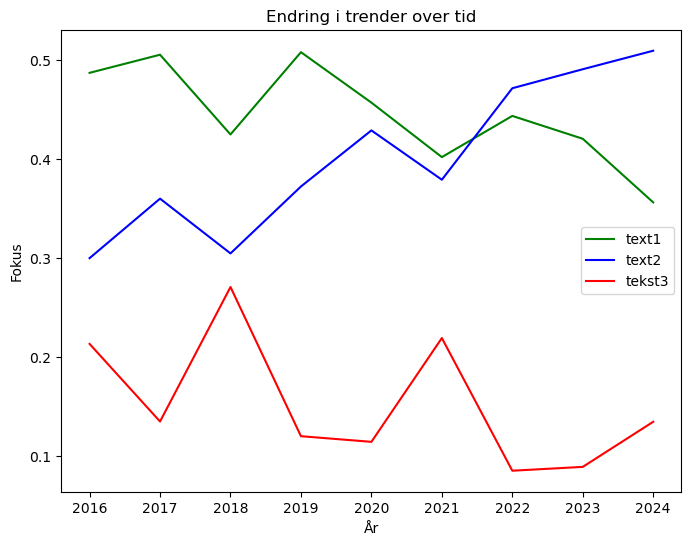

In [26]:
import matplotlib.pyplot as plt

years = range(2016, 2025)

# Sett opp plot
plt.figure(figsize=(8, 6))
plt.plot(years, centroid_1_values, 'g-', label="text1") #centroid1
plt.plot(years, centroid_2_values, 'b-', label="text2") #centroid2
plt.plot(years, centroid_3_values, 'r-', label="tekst3") #centroid3
plt.xlabel('År')
plt.ylabel('Fokus')
plt.title('Endring i trender over tid')

# Legg til en legend
plt.legend()

# Vis plottet
plt.show()


## Trender: Ett ord

In [29]:
# Average the embeddings for each year
mean_embeddings = [emb.mean(dim=0).numpy() for emb in text_embeddings]

mean_embeddings

[array([ 0.34267336,  0.58903885, -0.04372702, ..., -1.0807465 ,
        -0.57759476,  0.2693308 ], dtype=float32),
 array([ 0.2573317 ,  0.39258513, -0.1900722 , ..., -1.1565386 ,
        -0.5862084 ,  0.17565815], dtype=float32),
 array([ 0.21637367,  0.27790096, -0.1462012 , ..., -1.114886  ,
        -0.70084953,  0.24041098], dtype=float32),
 array([ 0.3084579 ,  0.52573806, -0.23526993, ..., -1.1351568 ,
        -0.4362622 ,  0.37928843], dtype=float32),
 array([ 0.3581431 ,  0.43783376, -0.2686381 , ..., -1.116644  ,
        -0.544963  ,  0.21410924], dtype=float32),
 array([ 0.3094682 ,  0.54865134, -0.15052861, ..., -1.0879618 ,
        -0.4746925 ,  0.24485879], dtype=float32),
 array([ 0.22245272,  0.4727047 , -0.35373348, ..., -0.89436203,
        -0.38583446,  0.2845176 ], dtype=float32),
 array([ 0.3404096 ,  0.5370492 , -0.17731668, ..., -0.99929506,
        -0.39034832,  0.22795507], dtype=float32),
 array([ 0.49007818,  0.63084036, -0.02246108, ..., -0.8651808 ,
       

In [30]:
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [41]:
# Centroid: Ordet vi sammenlikner med

centroid = "‘Baptiste Oil and Gas invests in the development of CCS because this is in line with our corporate social responsibility policy. If we do not invest in this technology now, the amount of CO2 in the atmosphere will continue to increase, causing the mean temperature on earth to rise. This has several negative effects for humankind and nature, like disturbance of the present ecosystems, extinction of some plant- and animal species, and a rising sea level, with all its consequences. By implementing CCS on a large scale, less CO2 will be emitted into the air, which makes it possible to prevent the aforementioned ecological problems. In short, we invest in the development of CCS because of the natural environment.’For participants in the economic motive condition, the website read:‘Baptiste Oil and Gas invests in the development of CCS because we expect to profit from it in the long run. By being involved in the development of this technology, we gain important knowledge and experience. In the future, we can export this expertise. This will have beneficial effects on our turnover. Also, we expect to enhance our profit by trading our emission rights, the so-called emissions trade. Firms have the right to emit a certain amount of carbon dioxide. By using CCS, Baptiste Oil and Gas will emit almost no carbon dioxide but remains the rights to emit it. Therefore, we can sell our rights to other companies in order to enable them to emit more carbon dioxide than they are entitled to. In short, we invest in the development of CCS because of the profit.’"
centroid_embedding = model.encode(centroid, convert_to_tensor=True).reshape(1, -1).tolist()


In [32]:
# Gir embeddingene en score basert på avstand til centroid-ordet

def embedding_score(text_embeddings, centroid_embedding,alpha):
    distances = sc.spatial.distance.cdist(mean_embeddings, centroid_embedding, "cosine")
    score = 1/(distances**alpha)
    sum = score.sum()
    return score/sum

In [42]:
scores = embedding_score(mean_embeddings, centroid_embedding, 5)

print(scores)

[[0.05270387]
 [0.07166771]
 [0.09238455]
 [0.10167072]
 [0.11841244]
 [0.15835376]
 [0.11079316]
 [0.1294723 ]
 [0.16454151]]


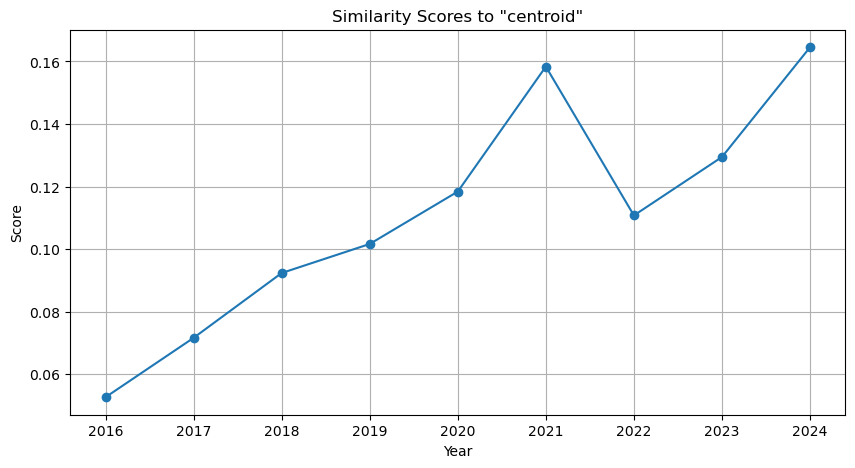

In [43]:
# Function to plot the scores with the centroid word as the title
def plot_scores(scores, centroid_word):
    years = list(range(2016, 2025))  # Assuming the years are from 2015 to 2024
    plt.figure(figsize=(10, 5))
    plt.plot(years, scores, marker='o')
    plt.title(f'Similarity Scores to "centroid"')
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# Plot the scores
plot_scores(scores, centroid)

In [ ]:
## Embedding scores by year

fig, ax = plt.subplots()

years = np.array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

# Define the gradient
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient)).T

# Plot the gradient background directly on the axes
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn_r'), alpha=0.5, extent=[0, 1, 0, 1], transform=ax.transAxes)

# Customize the plot
plt.xlim(2014.5,2024.5)
plt.ylim(min(scores) - 0.005, max(scores) + 0.005)

ax.set_facecolor('none')

# Plot the data
plt.plot(years,scores,"ro")

plt.xticks(years, rotation=45, ha='right')

# Create and plot the line of best fit
X = years.reshape(-1, 1)
y = scores
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.plot(years, y_pred, color='blue', linestyle='--', linewidth=2, label='Best Fit Line')


plt.xlabel("Years")
plt.ylabel(f"Distance score (compared to centroid)")
plt.title(f'Similarity Scores to "centroid"')


plt.show()